In [ ]:
import pandas as pd
import torch
import spacy
from selfcheckgpt.modeling_selfcheck import (
    SelfCheckMQAG, SelfCheckBERTScore, SelfCheckNgram, SelfCheckNLI
)
from selfcheckgpt.modeling_selfcheck_apiprompt import SelfCheckAPIPrompt

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize SelfCheck modules
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selfcheck_mqag = SelfCheckMQAG(device=device)
selfcheck_bertscore = SelfCheckBERTScore(rescale_with_baseline=True)
selfcheck_ngram = SelfCheckNgram(n=1)
selfcheck_nli = SelfCheckNLI(device=device)

# Initialize API-based SelfCheck (replace with your API key)
import os
os.environ["OPENAI_API_KEY"] = 
selfcheck_prompt = SelfCheckAPIPrompt(client_type="openai", model="gpt-3.5-turbo")

# Load dataset from file (replace 'your_file.csv' with actual filename)
df = pd.read_csv(r'D:\liulanqi1\MindMap-main\MindMap-main\实验结果\output.csv')

systems = ["MindMap", "GPT3.5", "BM25_retrieval", "Embedding_retrieval", "KG_retrieval", "KG_self-consistency", "GPT4"]

all_results = []

# for idx, row in df.iterrows():
#     label = row['Label']
#     label_sentences = [sent.text.strip() for sent in nlp(label).sents]

#     for system in systems:
#         passage = row[system]

#         # MQAG
#         mqag_scores = selfcheck_mqag.predict(
#             sentences=label_sentences,
#             passage=label,
#             sampled_passages=[passage],
#             num_questions_per_sent=5,
#             scoring_method='bayes_with_alpha',
#             beta1=0.8, beta2=0.8
#         )

#         # BERTScore
#         bert_scores = selfcheck_bertscore.predict(
#             sentences=label_sentences,
#             sampled_passages=[passage]
#         )

#         # Ngram
#         ngram_scores = selfcheck_ngram.predict(
#             sentences=label_sentences,
#             passage=label,
#             sampled_passages=[passage]
#         )

#         # NLI
#         nli_scores = selfcheck_nli.predict(
#             sentences=label_sentences,
#             sampled_passages=[passage]
#         )

#         # LLMPrompt (API)
#         prompt_scores = selfcheck_prompt.predict(
#             sentences=label_sentences,
#             sampled_passages=[passage],
#             verbose=False
#         )

#         all_results.append({
#             "Row": idx,
#             "System": system,
#             "MQAG": mqag_scores.tolist(),
#             "BERTScore": bert_scores.tolist(),
#             "Ngram_avg_neg_logprob": ngram_scores['doc_level']['avg_neg_logprob'],
#             "NLI": nli_scores.tolist(),
#             "LLMPrompt": prompt_scores
#         })

# Only process the first row
first_row = df.iloc[0]
label = first_row['Label']
label_sentences = [sent.text.strip() for sent in nlp(label).sents]

for system in systems:
    passage = first_row[system]

    # MQAG
    mqag_scores = selfcheck_mqag.predict(
        sentences=label_sentences,
        passage=label,
        sampled_passages=[passage],
        num_questions_per_sent=1,
        scoring_method='bayes_with_alpha',
        beta1=0.8, beta2=0.8
    )

    # BERTScore
    bert_scores = selfcheck_bertscore.predict(
        sentences=label_sentences,
        sampled_passages=[passage]
    )

    # Ngram
    ngram_scores = selfcheck_ngram.predict(
        sentences=label_sentences,
        passage=label,
        sampled_passages=[passage]
    )

    # NLI
    nli_scores = selfcheck_nli.predict(
        sentences=label_sentences,
        sampled_passages=[passage]
    )

    # LLMPrompt (API)
    prompt_scores = selfcheck_prompt.predict(
        sentences=label_sentences,
        sampled_passages=[passage],
        verbose=False
    )

    all_results.append({
        "System": system,
        "MQAG": mqag_scores.tolist(),
        "BERTScore": bert_scores.tolist(),
        "Ngram_avg_neg_logprob": ngram_scores['doc_level']['avg_neg_logprob'],
        "NLI": nli_scores.tolist(),
        "LLMPrompt": prompt_scores
    })
results_df = pd.DataFrame(all_results)

print(results_df)


SelfCheck-MQAG initialized to device cuda
SelfCheck-BERTScore initialized
SelfCheck-1gram initialized
SelfCheck-NLI initialized to device cuda
Initiate OpenAI client... model = gpt-3.5-turbo
                System                                       MQAG  \
0              MindMap  [0.3170191333288569, 0.22589367103330907]   
1               GPT3.5   [0.3908867390802924, 0.2227804058230451]   
2       BM25_retrieval    [0.646826160937995, 0.2028705469156623]   
3  Embedding_retrieval   [0.4007669863583889, 0.7829011610105685]   
4         KG_retrieval   [0.7207207075929289, 0.7912689616604839]   
5  KG_self-consistency  [0.28203115691901703, 0.7989291602491548]   
6                 GPT4   [0.7852911561890032, 0.7845629225252898]   

                                   BERTScore  Ngram_avg_neg_logprob  \
0  [0.42789846658706665, 0.5530085563659668]               5.064544   
1   [0.4255948066711426, 0.7796068042516708]               3.952692   
2  [0.47933363914489746, 0.7557316422462463

In [2]:
import pandas as pd

# 假设 all_results 已经存在
results_df = pd.DataFrame(all_results)

# 保存为 CSV 文件
output_file = r'D:\liulanqi1\MindMap-main\MindMap-main\实验结果\selfcheckgpt_results.csv'
results_df.to_csv(output_file, index=False)

print(f"结果已保存到 {output_file}")


结果已保存到 D:\liulanqi1\MindMap-main\MindMap-main\实验结果\selfcheckgpt_results.csv


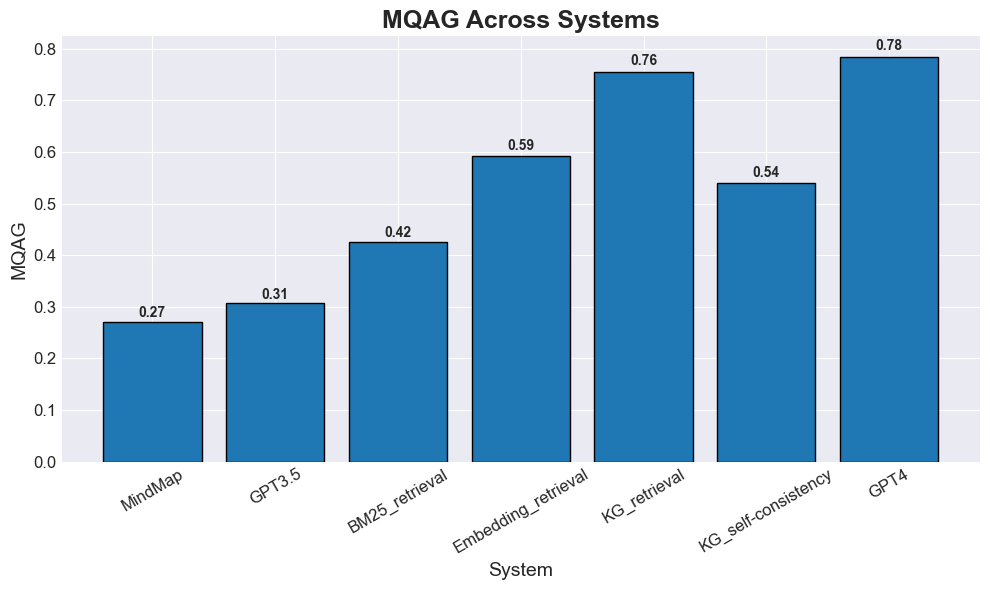

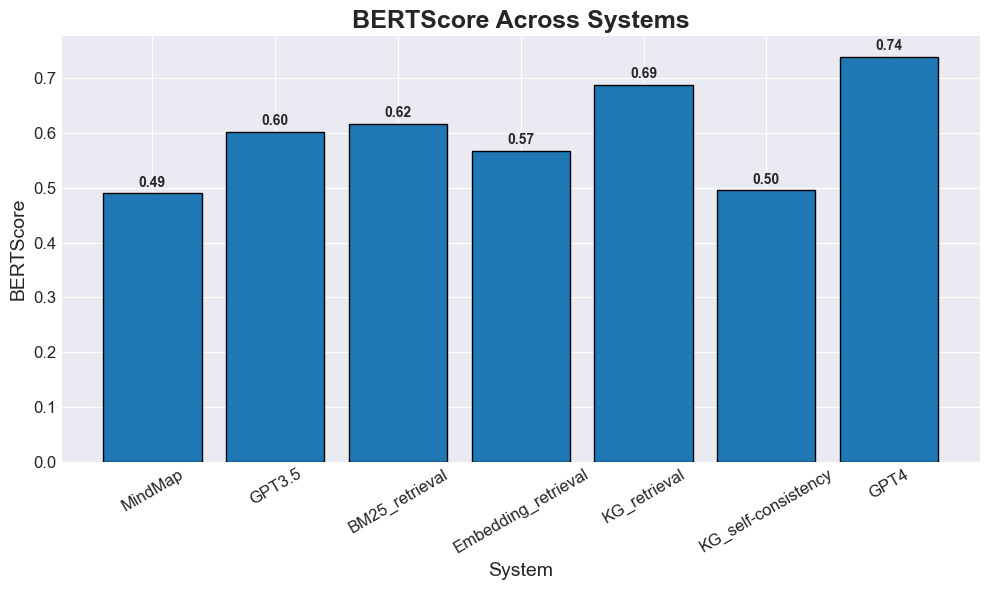

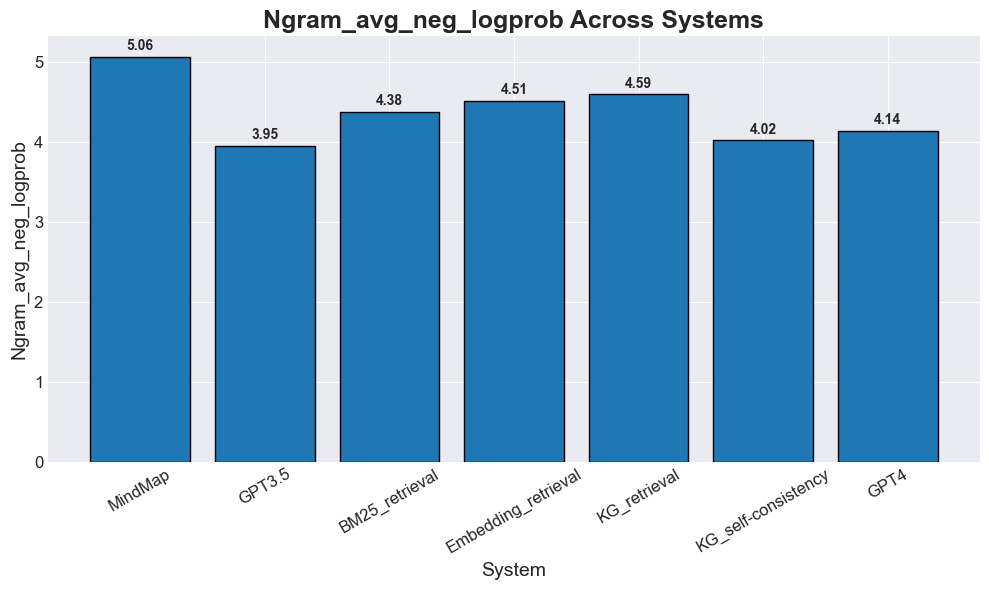

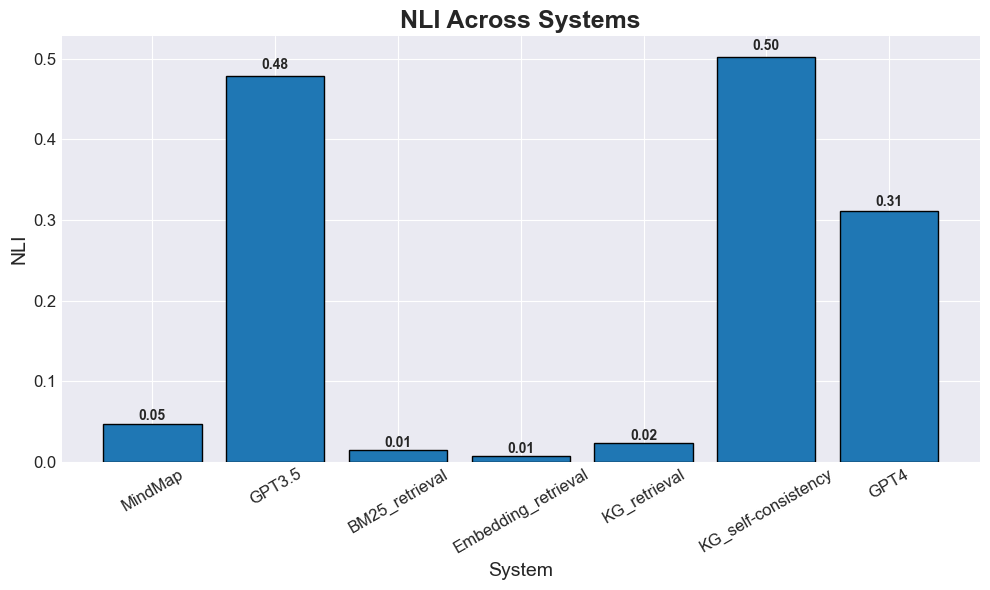

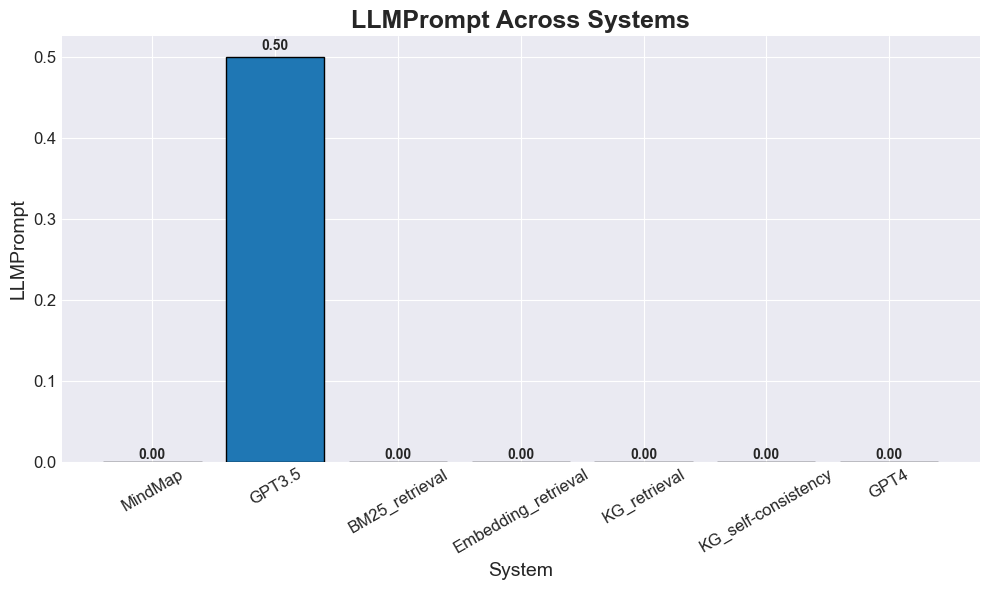

In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import re

# 清理多值字段：统一格式
def clean_list_string(s):
    s = re.sub(r'\s+', ',', s)
    s = re.sub(r',+', ',', s)
    s = s.strip('[], ')
    return f"[{s}]"

# 读取 CSV 文件
df = pd.read_csv('selfcheckgpt_results.csv')  # 替换为你的实际文件路径

# 清理并将字符串列表转为数字列表
for col in ['MQAG', 'BERTScore', 'NLI', 'LLMPrompt']:
    df[col] = df[col].apply(clean_list_string).apply(lambda x: ast.literal_eval(x))

# 计算均值
df['MQAG'] = df['MQAG'].apply(lambda x: sum(x)/len(x))
df['BERTScore'] = df['BERTScore'].apply(lambda x: sum(x)/len(x))
df['NLI'] = df['NLI'].apply(lambda x: sum(x)/len(x))
df['LLMPrompt'] = df['LLMPrompt'].apply(lambda x: sum(x)/len(x))

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')

# 绘制图表
metrics = ['MQAG', 'BERTScore', 'Ngram_avg_neg_logprob', 'NLI', 'LLMPrompt']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['System'], df[metric], edgecolor='black')
    plt.title(f'{metric} Across Systems', fontsize=18, weight='bold')
    plt.xlabel('System', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=30, fontsize=12)
    plt.yticks(fontsize=12)
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.2f}', 
                 ha='center', va='bottom', fontsize=10, weight='bold')
    plt.tight_layout()
    plt.show()
